# Nima Vahdat 610397163

## Importing libraries

In [1]:
import pandas as pd
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl 

## Cleaning data

### We need to clean the data and normalize it
1. Lower -> All letters must be lowercase so that the model will perform equally well.
2. Only alphabet -> All characters should be alphabets or spaces.
3. Spell Checking -> We should check and fix the spelling errors in the text
5. Normalization -> I use the lemmatization method, which removes only inflectional endings and returns the dictionary form of each word. 

I have therefore defined a function that handles all of those things for us.

In [2]:
spell = Speller(lang='en')
wordnet_lemmatizer = WordNetLemmatizer()

def text_cleaner(text):
    
    # The letters become lowercase
    text = text.lower()
    
    # Only save alphabetical characters
    cleaned_text = ''
    for char in text:
        if (char.isalpha()) or (char == ' '):
            cleaned_text += char
    
    # Correct Spelling
    cleaned_text = spell(cleaned_text)
    
    # Normalization
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word)for word in nltk.word_tokenize(text)]
    cleaned_text = " ".join(lemmatized_word)

    return cleaned_text

## Vectorizing
I will use two methods for vectorizing and compare their results on different classification methods

1. CountVectorizer: Convert a collection of text documents to a matrix of token counts.
2. TfidfVectorizer: Convert a collection of raw documents to a matrix of TF-IDF features



In [3]:
# Making vectorizers
count_vectorizer = CountVectorizer(analyzer = "word") 
tfidf_vectorizer = TfidfVectorizer(analyzer = "word")

The following function gets a classification model and gives us the results.
For evaluating models we use 10-Fold Cross Validation.

In [4]:
vectorizers = [count_vectorizer, tfidf_vectorizer]
vectorizers_names = ['Count Vectorizer', 'TF-IDF Vectorizer']

def train(clf, clf_name, df):
    results = [0, 0]
    for i in range(len(vectorizers)):
        print(vectorizers_names[i])
        vectorizer = vectorizers[i]
        
        # Vectorizing
        X = vectorizer.fit_transform(df['text'])
        y = df['sentiment']
        
        # Seprating Dataset for 10-Fold Cross Validation
        cv = ShuffleSplit(10, test_size=0.2, random_state=0)
        
        # Feeding data into model and getting mean
        results[i] = cross_val_score(clf, X, y, cv=cv).mean()
        
        print(clf_name+'_result:', results[i])
        
    return results 

# SandersPosNeg

## Importing dataset SandersPosNeg.csv

We import the dataset and rename the columns here

In [5]:
df_san = pd.read_csv("SandersPosNeg.csv", header=None, sep="\t")
df_san.rename(columns={0: "sentiment", 1: "text"}, inplace=True)
df_san.head()

,sentiment,text
0,0,RT @cjwallace03: So apparently @apple put MB c...
1,0,RT @Jewelz2611 @mashable @apple iphones r 2 ex...
2,0,@mashable @apple iphones r 2 expensive. Most w...
3,0,THiS IS WHAT WiLL KiLL APPLE http://t.co/72Jw4...
4,4,Now all @Apple has to do is get swype on the i...


Now let's get the information about the dataset.

In [6]:
df_san.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1224 non-null   int64 
 1   text       1224 non-null   object
dtypes: int64(1), object(1)
memory usage: 19.2+ KB


## Visualisation on data

<AxesSubplot:ylabel='Frequency'>

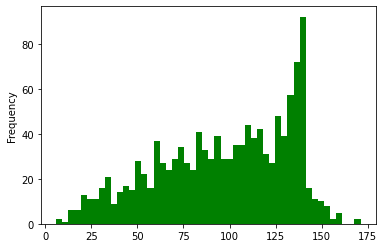

In [7]:
df_san['length'] = df_san['text'].apply(len)
df_san['length'].plot(kind = 'hist' , bins = 50, color = 'green') 

Text(0.5, 0.98, 'Length via each Sentiment')

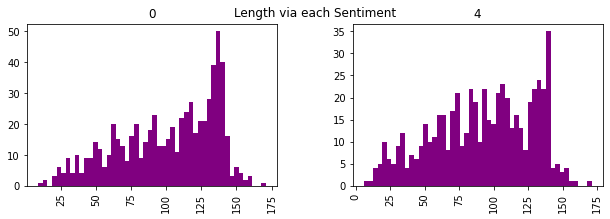

In [8]:
ax = df_san.hist(column = 'length', by = 'sentiment', bins = 50 , figsize = (10, 3), color = 'purple');
pl.suptitle('Length via each Sentiment')

We can see from the results above that negative people tend to write longer tweets than someone who is positive.

We now apply the function to the data

In [9]:
# Cleaning text
df_san["text"] = df_san["text"].apply(text_cleaner)

# Naive Bayes

In [10]:
clf = MultinomialNB(alpha=0.49)
nb_results = train(clf, 'NaiveBayes', df_san)

Count Vectorizer
NaiveBayes_result: 0.8175510204081633
TF-IDF Vectorizer
NaiveBayes_result: 0.8281632653061223


# Random Forest

In [11]:
clf = RandomForestClassifier(400, criterion='entropy')
rf_results = train(clf, 'RandomForest', df_san)

Count Vectorizer
RandomForest_result: 0.8200000000000001
TF-IDF Vectorizer
RandomForest_result: 0.796734693877551


# SVM

In [12]:
clf = SVC(kernel='linear')
svm_results = train(clf, 'SVM', df_san)

Count Vectorizer
SVM_result: 0.8216326530612245
TF-IDF Vectorizer
SVM_result: 0.8351020408163266


# MLP

In [13]:
clf = MLPClassifier(solver='lbfgs', alpha=0.4, learning_rate='invscaling',
                    hidden_layer_sizes=(110), random_state=1)
mlp_results = train(clf, 'MLP', df_san)

Count Vectorizer
MLP_result: 0.8244897959183675
TF-IDF Vectorizer
MLP_result: 0.8379591836734696


# Comparing
We now compare the results of different classification methods.

<BarContainer object of 2 artists>

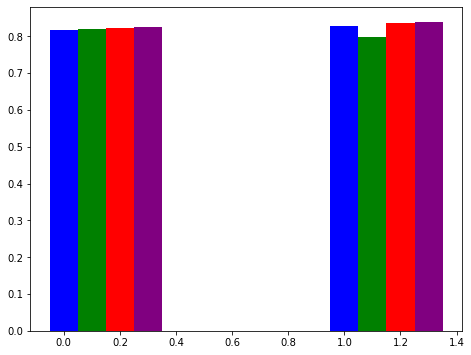

In [14]:
import numpy as np
data = [nb_results, rf_results, svm_results, mlp_results]

X = np.arange(2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.75,0.75,0.75,0.75])
ax.bar(X + 0.0, data[0], color = 'blue', width = 0.1)
ax.bar(X + 0.1, data[1], color = 'green', width = 0.1)
ax.bar(X + 0.2, data[2], color = 'red', width = 0.1)
ax.bar(X + 0.3, data[3], color = 'purple', width = 0.1)

# OMD
## Importing dataset OMD.csv
We import the dataset and rename the columns here

In [15]:
df_omd = pd.read_csv("OMD.csv", header=None, sep="\t", encoding='mac_roman')
df_omd = df_omd[0].str.split(',', n=1, expand=True)
df_omd.rename(columns={0: "sentiment", 1: "text"}, inplace=True)
df_omd.head()

,sentiment,text
0,0,Watching by myself #tweetdebate Not drinking ...
1,0,"@ahg3 @MichDot Yeah, slime was actually my sec..."
2,0,"Preparing to have a heart attack #tweetdebate,"
3,0,"no debate moderators under 50, sorry #tweetde..."
4,0,@current Now staring at black screen on http:/...


Now let's get the information about the dataset.

In [16]:
df_omd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1906 non-null   object
 1   text       1906 non-null   object
dtypes: object(2)
memory usage: 29.9+ KB


## Visualisation on data

<AxesSubplot:ylabel='Frequency'>

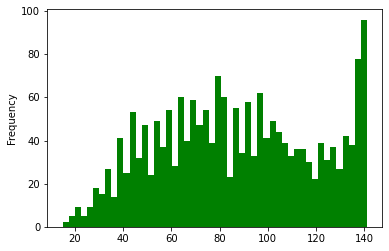

In [17]:
df_omd['length'] = df_omd['text'].apply(len)
df_omd['length'].plot(kind = 'hist' , bins = 50, color = 'green') 

Text(0.5, 0.98, 'Length via each Sentiment')

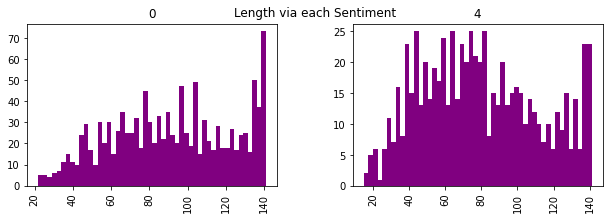

In [18]:
ax = df_omd.hist(column = 'length', by = 'sentiment', bins = 50 , figsize = (10, 3), color = 'purple');
pl.suptitle('Length via each Sentiment')

We now apply the function to the data

In [19]:
# Cleaning text
df_omd["text"] = df_omd["text"].apply(text_cleaner)

# Naive Bayes

In [20]:
clf = MultinomialNB(alpha=0.48)
nb_results = train(clf, 'NaiveBayes', df_omd)

Count Vectorizer
NaiveBayes_result: 0.7732984293193716
TF-IDF Vectorizer
NaiveBayes_result: 0.7659685863874346


# Random Forest

In [21]:
clf = RandomForestClassifier(250, criterion='entropy')
rf_results = train(clf, 'RandomForest', df_omd)

Count Vectorizer
RandomForest_result: 0.7858638743455498
TF-IDF Vectorizer
RandomForest_result: 0.769371727748691


# SVM

In [22]:
clf = SVC(kernel='linear')
svm_results = train(clf, 'SVM', df_omd)

Count Vectorizer
SVM_result: 0.7693717277486911
TF-IDF Vectorizer
SVM_result: 0.7971204188481675


# MLP

In [23]:
clf = MLPClassifier(solver='lbfgs', alpha=0.2, learning_rate='invscaling',
                    hidden_layer_sizes=(85), random_state=1)
mlp_results = train(clf, 'MLP', df_omd)

Count Vectorizer
MLP_result: 0.7801047120418849
TF-IDF Vectorizer
MLP_result: 0.7821989528795812


# Comparing
We now compare the results of different classification methods.

<BarContainer object of 2 artists>

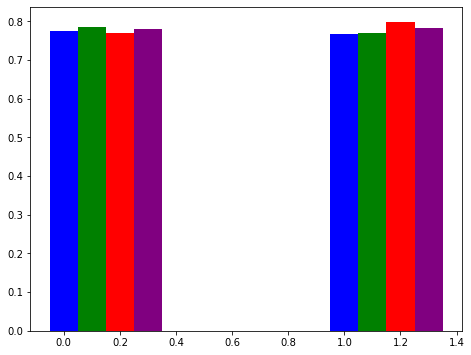

In [24]:
import numpy as np
data = [nb_results, rf_results, svm_results, mlp_results]

X = np.arange(2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.75,0.75,0.75,0.75])
ax.bar(X + 0.0, data[0], color = 'blue', width = 0.1)
ax.bar(X + 0.1, data[1], color = 'green', width = 0.1)
ax.bar(X + 0.2, data[2], color = 'red', width = 0.1)
ax.bar(X + 0.3, data[3], color = 'purple', width = 0.1)